## Time Series Decomposition II
<br>  
**Objectives**  
- Learn how to decompose time series data into trend, seasonal and cycle components

**quick review of lec03**
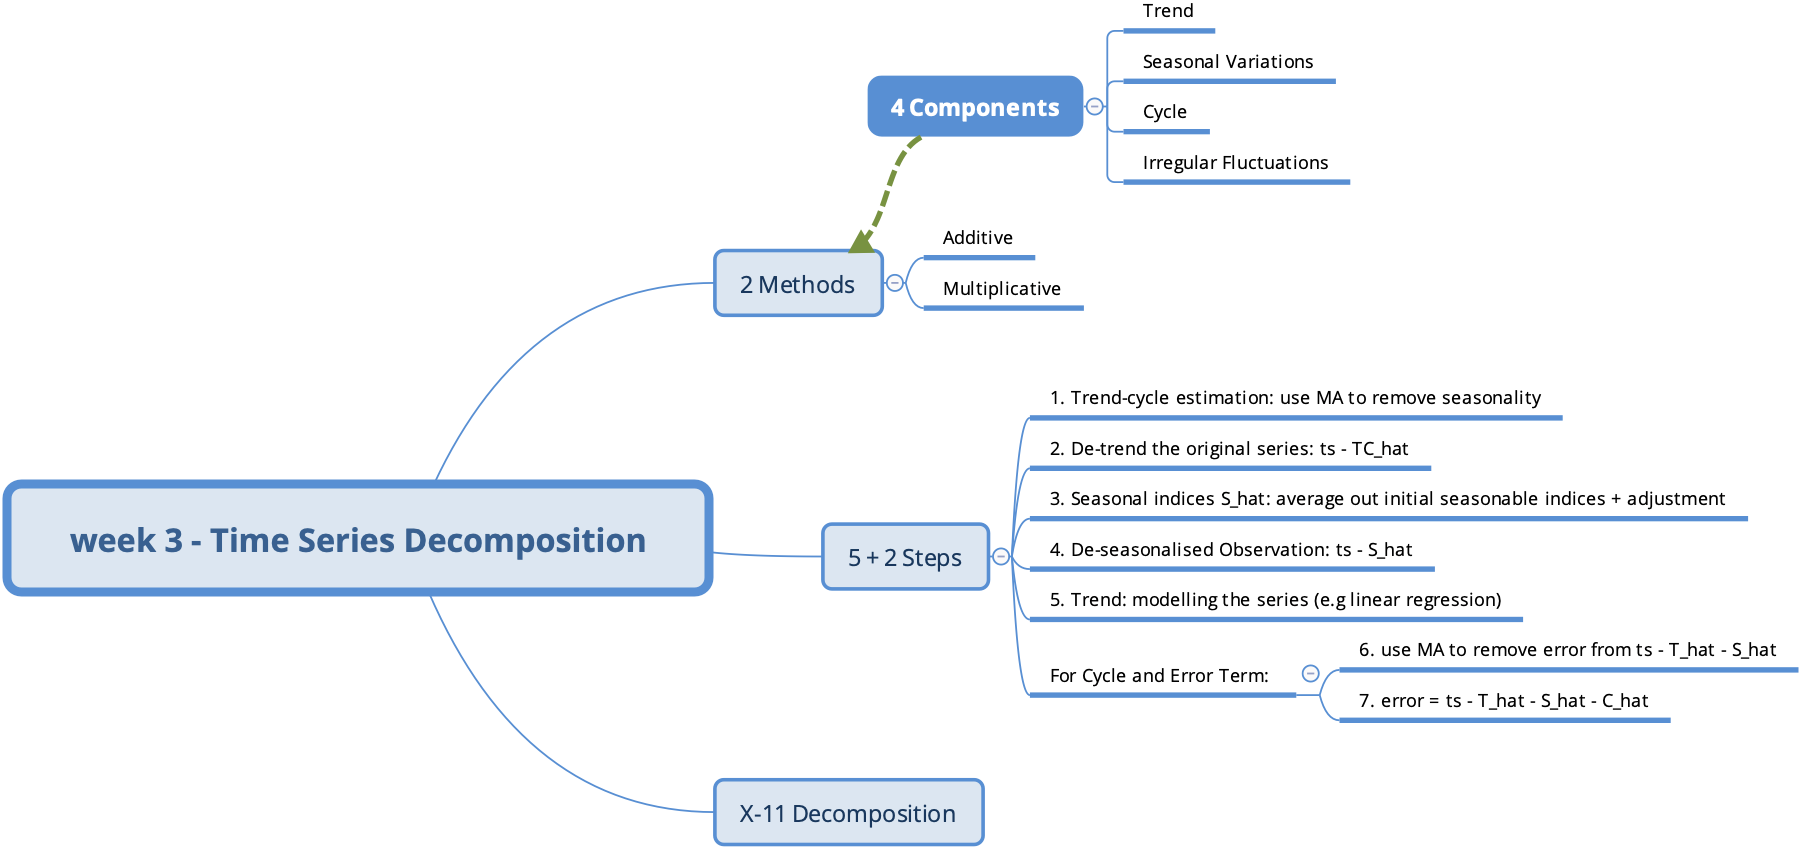

**quick review of tut03**  
1. moving average  
`ts.rolling(12, center = True).mean()`  


2. log transformation  
`np.log(ts)`  


3. stationary  
    - visualization: constant mean and std
    - Dickey-fuller Test

In our previous tutorial, we have learnt the data manipulation in Time Series, i.e. loading the dataset from a csv file, indexing the data, visualizing the data, moving average and how to check stationary with the help of moving average.

In this week, we will further learn how to decompose a time series data by <span class="mark">using trend-cycle decomposition</span>.

Here are the main steps we may take:  
(1) Analyze the stationarity  
(2) Estimate the initial trend-cycle component $\hat{𝑇_t}$  
(3) Estimate the seasonal component and seasonal index $\hat{𝑆_t}$  
(4) Update the estimation of the trend-cycle component $\hat{𝑇_t}$  
(5) * If you want to use this decomposition method for forecasting, then you need to combine the seasonal index $\hat{𝑆_t}$ and final trend-cycle $\hat{T_t}$ together as the forecasting result

In our previous tutorial, we have learnt the fundamental of the stationarity analysis and initial trend-cycle estimation. For today’s tutorial, we will mainly focus on the steps 3-4 from above list.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%config InlineBackend.figure_format='retina'

from datetime import datetime

### 1. Calculate initial trend-cycle estimation by moving average   
Continue with the task 5 in our last tutorial. At the end of last tutorial, you have get time series data `ts_res` (which is stationary). Generally, this `ts_res` is the seasonal component $𝑆_t + 𝑒_t$. Although you have done this task with correct actions, you still need to pay attention to the following tips.

**Firstly**, when examining the seasonal peaks (reduce the trend), we use the log transform so that we could penalizes larger values more than the smaller. However, for some other cases, we may also apply different transformation methods such as exponent, or cube root etc.

**Secondly**, to calculate the initial trend-cycle estimate, we need to do <span class="burk">moving average smoothing to remove the seasonal fluctuation</span>. For even seasonal period m, we must do a <span class="mark">“2 by m”-MA.</span> For any odd seasonal period m, we must do a m-MA.

**Thirdly**, the selection of decomposition type is important.

Basically, we have 2 main decomposition type: additive and multiplicative.

- If the seasonal variation is proportional to the trend, then we should use multiplicative. If the <span class="mark">seasonal peaks increase in magnitude</span> when the trends magnitude increases and vice versa then it is proportional.
- Otherwise we should use additive.

Review the case in last tutorial, we choose the additive decomposition as the peaks are not proportional/multiplicative.

One thing we need to pay attention, for most cases, we will treat the moving average results as the combination of trend and cycle. That is:  

$$T_t + C_t = Moving \ Average (Y_t)$$   

Since in most cases, cycle $𝐶_t$ is hard to model, we will not take this component into account. Therefore:  

$$T_t = T_t + C_t$$  

Examine the following time-series curve and think about what is the suitable decomposition method?

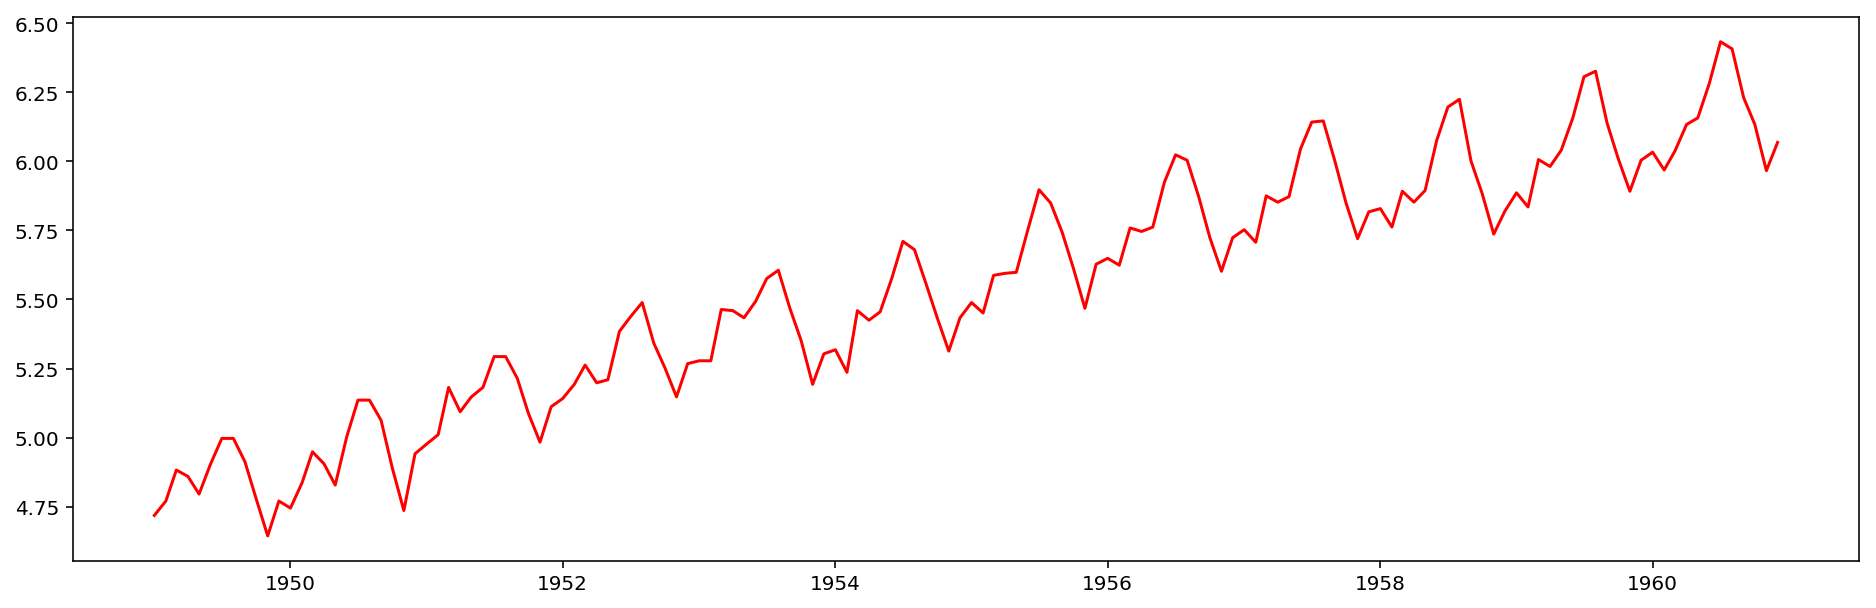

In [6]:
# import data and plot the log(ts) variable
data = pd.read_csv('AirPassengers.csv')
con = data['Month']
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace = True)
ts = data['Passengers']
ts_log = np.log(ts)

plt.figure(figsize = (16, 5))
plt.plot(ts_log, color = 'red',label = 'log');

In [43]:
# to decide the suitable decomposition method, try to answer the following questions:
# 1). can you recognize clear trend and seasonal compoenent?
# 2). the magnitude of seasonal term is propotionally changing with trend or not? *************
# 3). is the trend term (approximately) linear?

# if you still cannot recognise the most proper method, you could try both of them, and choose the one with smaller error.

Once we decide the decomposition method, we then need to calculate seasonal components. In last tutorial, for additive decomposition type, we use:

$$S_t + e_t = Y_t + T_t$$

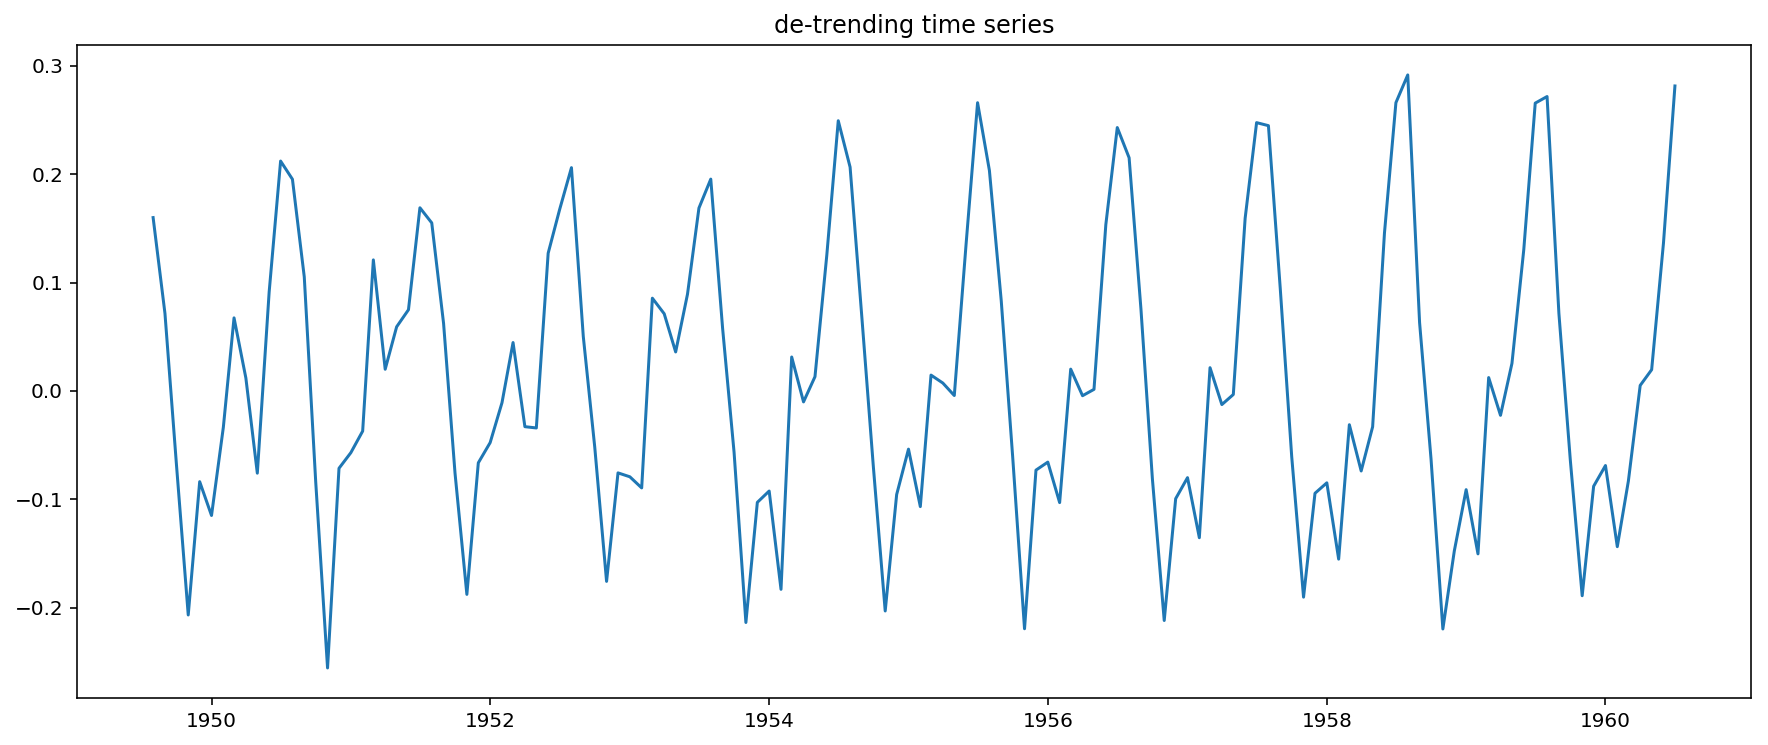

In [37]:
# use CMA-12 to get TC term
Trend = ts_log.rolling(2, center = True).mean().rolling(12,center = True).mean().shift(-1) # trend-cycle compoenent

# 144 num 12*12
# from 7 + 132 + 5
# to 6 + 132 + 6

ts_res = ts_log - Trend # ts - trend_cycle = seasonal + residual

plt.figure(figsize = (15, 6))
plt.plot(ts_res)
plt.title('de-trending time series');

Question: What if the trend is multiplicative / proportional?

In [ ]:
# additive      multiplicative
#    +               *
#    -               /

### 2. Calculate seasonal index
We assume that the season components are relatively stationary throughout the dataset ($𝑆_t = 𝑆_{t+m}$ and so on).

So now that we have identified the seasonal components we can eliminate them from the original data, which we can use to create an updated and <span class="mark">more accurate trend-cycle estimation</span>.

First take the average of the seasonal components for each month. To do this, we may need to replace the `nan` components with zeros. Although this is not a good strategy, but simple enough to demonstrate the concept and algorithm. Then pad the data so that we have 144 months (12 years) of observations. Then take the average.

$$\hat{S_t} = mean(S_t)$$

In [11]:
# use 0 to fill NaN cells
ts_res_zero = np.nan_to_num(ts_res)

# change the shape of ts_res_zero from (144,) to (12,12)
# in this case, one row indicates a year, and the same column is in the same month (Jan, Feb...)
# the first and last row should contain 0s. (explanation?)
monthly_S = np.reshape(ts_res_zero, (12,12))

# we choose from the 2-11 year (10 yrs in total) from the total 12 year 
# (we dropped the first and the last 2 years)
# axis = 0 means column-wised average operation
monthly_avg = np.mean(monthly_S[1:11, :], axis = 0)

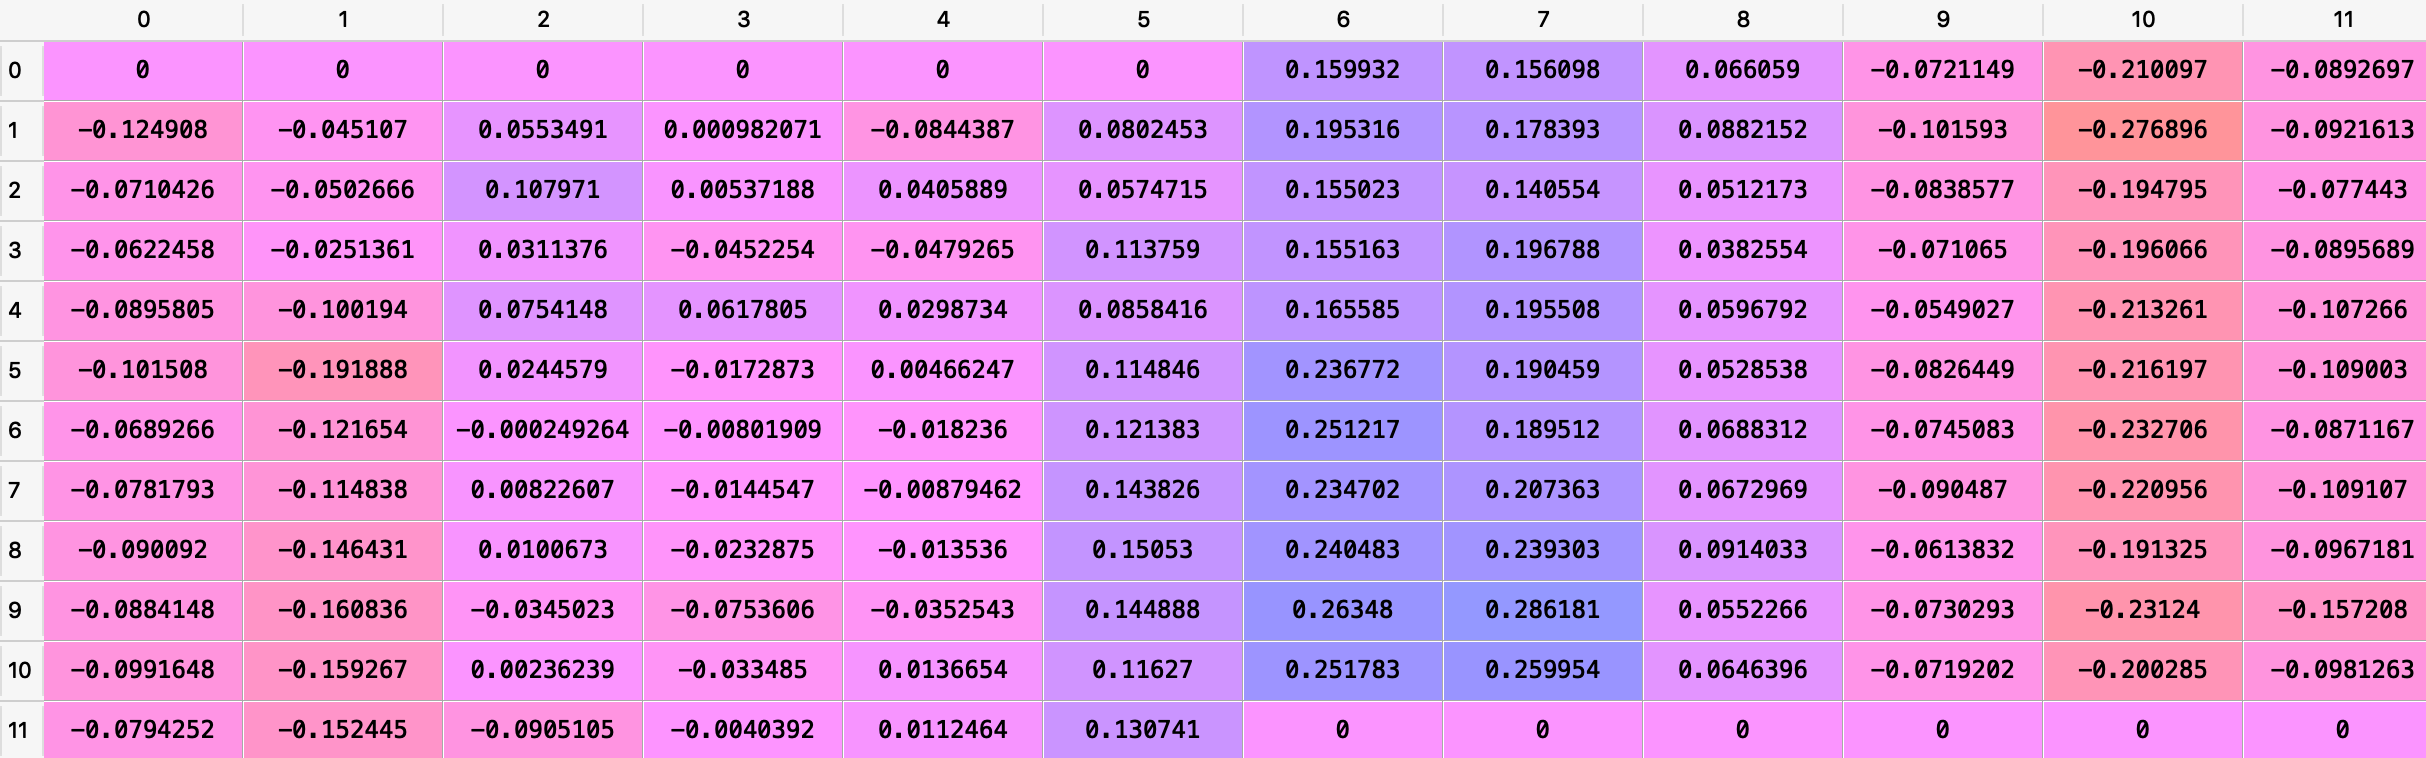

Before you copy the above code, think about the following questions:  
(1) What is the size of` monthly_S`?  
(2) What is the meaning of “1:11”?  
(3) If we don't want to use 0 to replace `nan`, what is your best suggestion? How to implement your suggestion in python code?

In [18]:
# question (1): use np.shape to check row and column numbers
np.shape(monthly_S)
# or print the variable if you are curious
# print(monthly_S)

(12, 12)

In [44]:
# question (2): check the result of monthly_S[1:11, :]
monthly_S[1:11, :]

In [ ]:
# question (3):check quick guide on Canvas
np.nanmean()

# https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmean.html

Then we should normalize our data in order to obtain a unique solution.   
For additive decomposition, we should make the <span class="mark">mean of seasonal index equal to zero</span>. Therefore, we should take the mean of the seasonal index out of the original seasonal index.   

$$\bar{S_t} = \hat{S_t} - mean\;(\hat{S_t})$$

In [38]:
#%% Normalize the seasonal index
mean_allmonth = monthly_avg.mean()
monthly_avg_normalized = monthly_avg - mean_allmonth
print(monthly_avg_normalized.mean())

5.782411586589357e-18


**Question**: What if the time series is multiplicative / the magnitude of time series is proportionally changing?
<br>
<br>
<br>

### 3. Calculate the seasonal adjusted data
In order to calculate the seasonal adjusted data $\hat{𝑆_t}$, you need to have original data $Y_t$ minus by the seasonal index $\hat{S_t}$:

$$𝑇_t + \hat{𝐶_t} + 𝑒_t = 𝑌_t − \hat{𝑆_t}$$

Since the size of original data $𝑌_t$ and seasonal index $\hat{𝑆_t}$ does not match, we need to repeat the $\hat{S_t}$ over 12 years:

In [39]:
# repeat the calculated seasonal index 12 times
tiled_avg = np.tile(monthly_avg, 12)
# now np.shape(tiled_avg) = (144,)
# means we prepared the index for all the 144 data

# check the difference with the emthod we used on the slide

Subtract the seasonal average from the original data:

In [40]:
seasonally_adjusted = ts_log - tiled_avg
# ts - seasonal = trend + cycle + irregular

Plot the seasonally adjusted data:

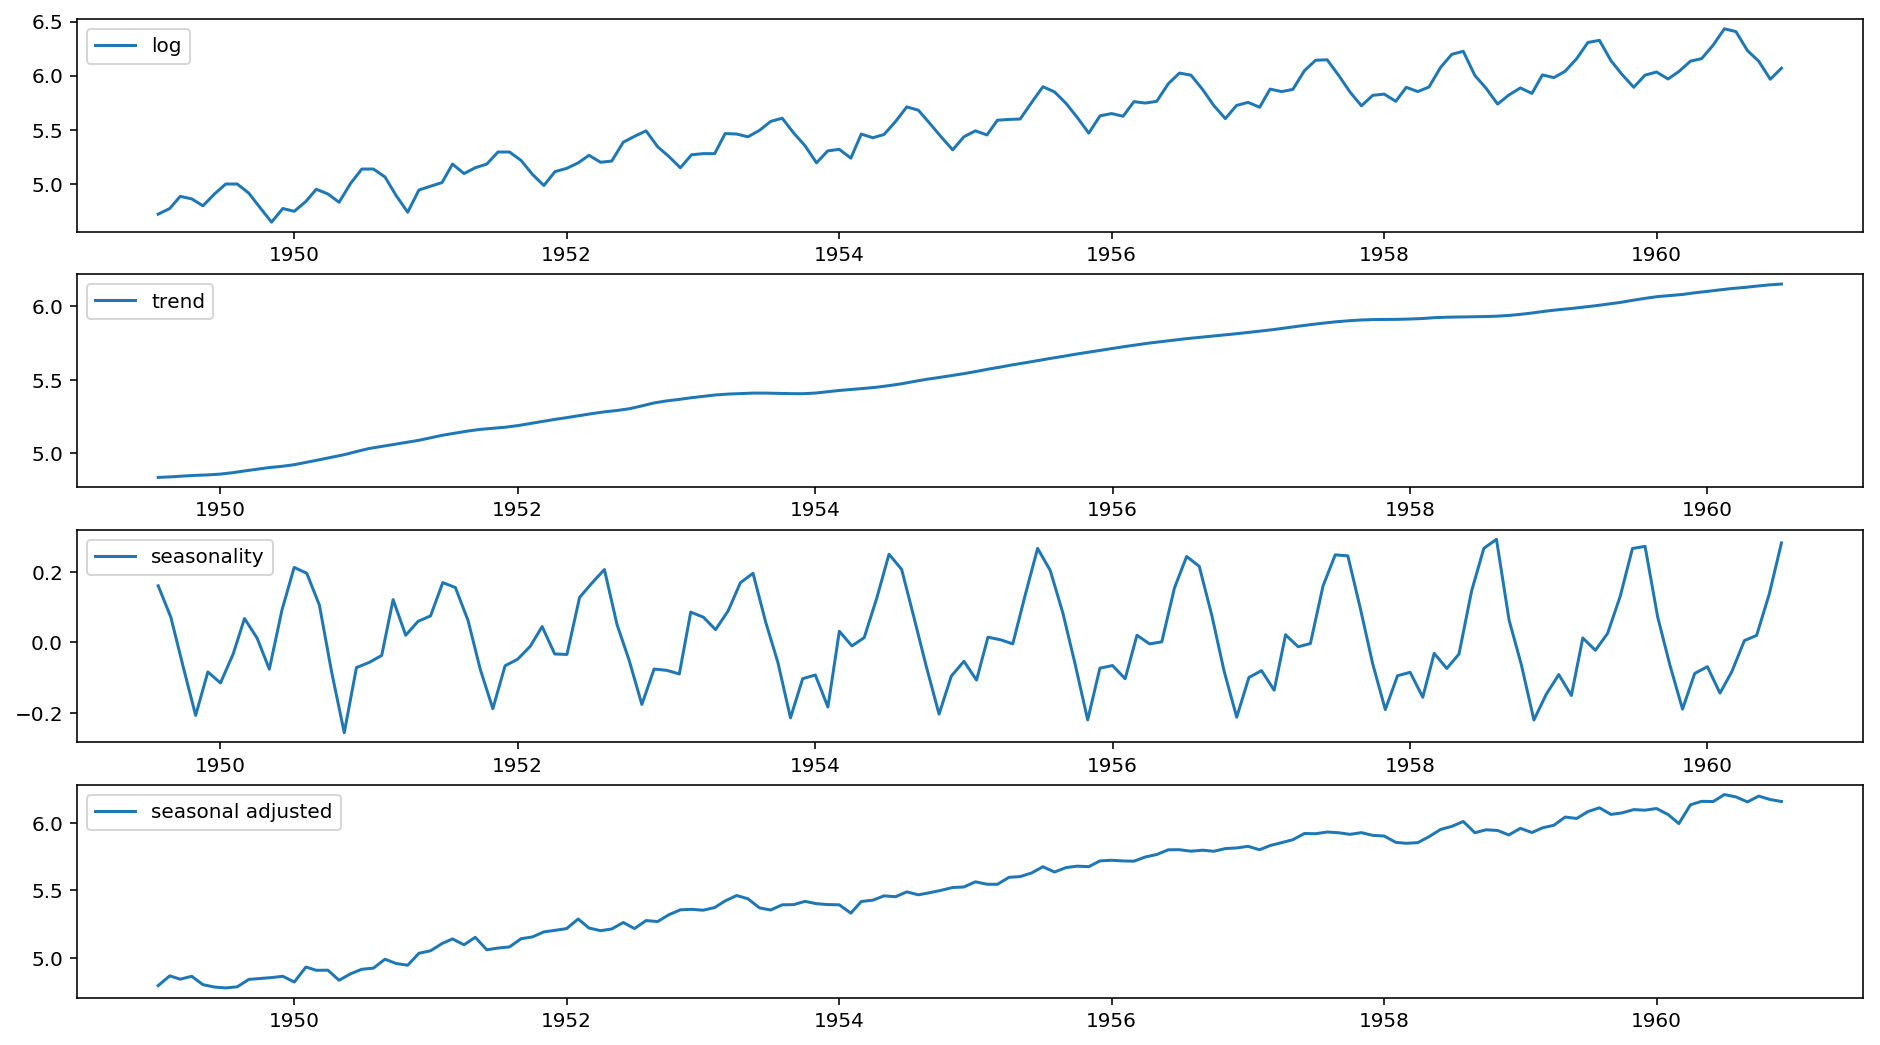

In [41]:
# draw a 4*1 subplot
fig, ax = plt.subplots(4, 1, figsize = (16, 9))
ax[0].plot(ts_log)
ax[1].plot(Trend) # trend + cycle
ax[2].plot(ts_res) # seasonal + irregular
ax[3].plot(seasonally_adjusted)
# set the legend
ax[0].legend(['log'], loc = 2)
ax[1].legend(['trend'], loc = 2)
ax[2].legend(['seasonality'], loc = 2)
ax[3].legend(['seasonal adjusted'], loc = 2);

### 4. Update the trend-cycle

Finally, we need to re-estimate the trend-cycle component based on the seasonally adjusted data $𝑇_t + \hat{𝐶_t} + 𝑒_t$. 

In here, there are many ways to update the trend-cycle component $\hat{T_t}$. You can use a linear representation to fit the data, or use a moving average method to regenerate the trend-cycle. For simplicity, we use a “2 by m” moving average to update the trend-cycle:

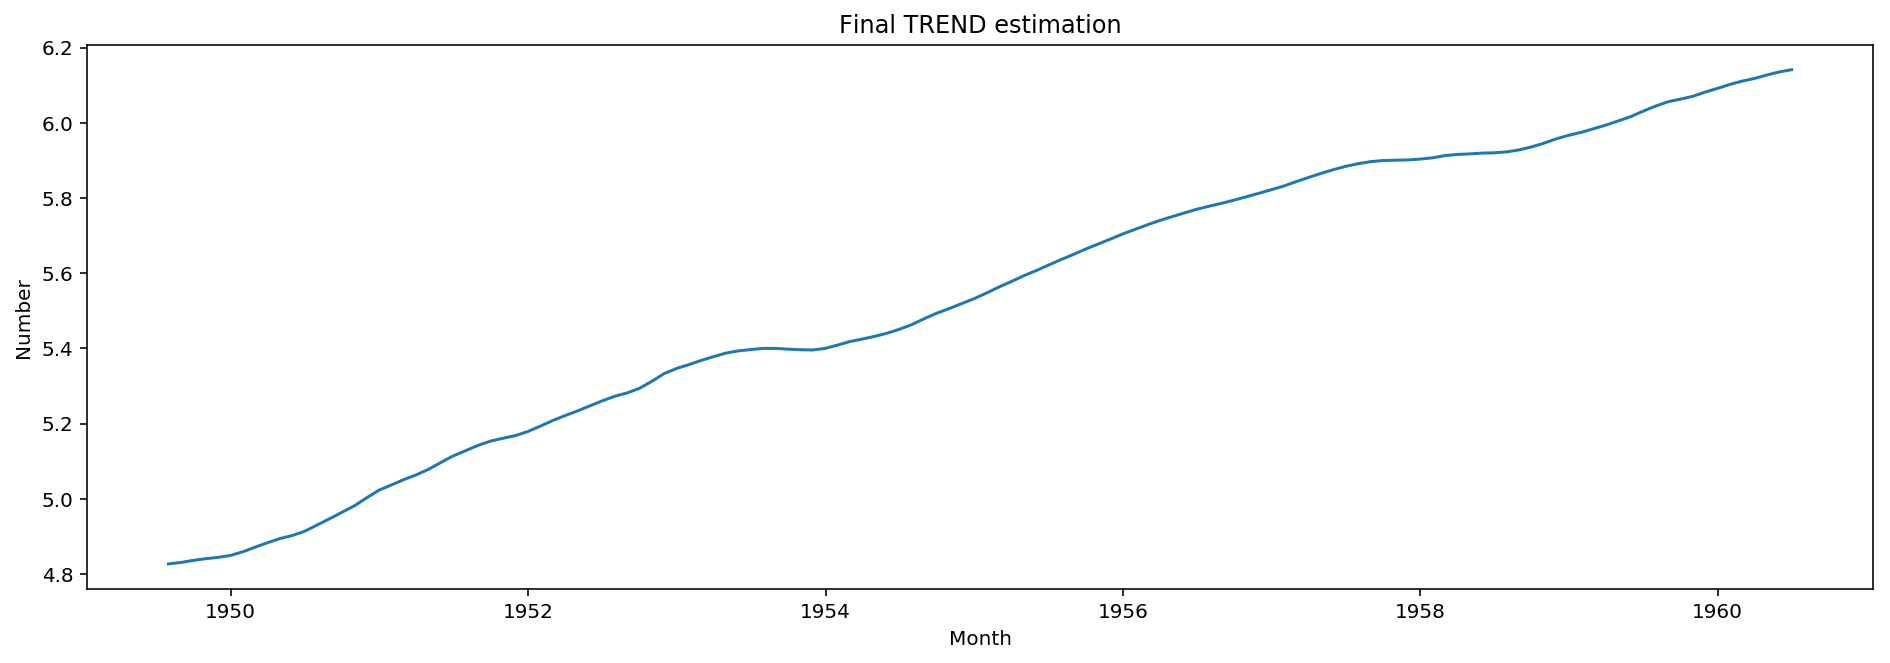

In [42]:
# apply CMA-12 to smooth the result of trend component
T_final = seasonally_adjusted.rolling(2, center =True).mean().rolling(12, center = True).mean()

plt.figure(figsize = (16, 5))
plt.plot(T_final)
plt.title('Final TREND estimation')
plt.xlabel('Month')
plt.ylabel('Number');

Now you have successfully extract the major components (trend-cycle, and seasonal index) from a time-series data.

If you are interested in topic and wish to learn more, please go to https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-usingpython-414fcb963000

We also updated the study guide for pandas rolling function. For further details on moving average and strategy to calculate seasonal index, please have a look at the below link:
https://canvas.sydney.edu.au/courses/14578/pages/course-resources 

When using pandas' mean, please make sure not counting NaNs in the detrended series.

**key words**  
`np.reshape()`   
`np.mean(array, axis = 0)`  
`array.mean()`  
`np.tile(array, 100)`  